In [176]:
# IMPORTS

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import os

In [177]:
if not os.path.exists('./Dumps/'):
    os.mkdir('./Dumps/')

if not os.path.exists('./Figs/'):
    os.mkdir('./Figs/')

In [178]:
# VARIABLES

file_path       : str = 'Eventos.csv'
alarm_desired   : str = 'Potência máxima ultrapassada'
columns_desired : list = ['Data e hora protocolo', 'Equipamento', 'Estado', 'Descrição', 'Valor']
# Try different encodings
encodings_to_try : list = ['utf-8', 'ISO-8859-1', 'cp1252']


In [179]:
# READ CSV DATA
for encoding in encodings_to_try:
    try:
        df : pd.DataFrame = pd.read_csv(file_path, encoding=encoding, sep=';', usecols=columns_desired, )
        # If successful, break out of the loop
        break
    except UnicodeDecodeError:
        print(f"Failed to decode with encoding {encoding}")

Failed to decode with encoding utf-8


In [180]:
# SEGREGATE ALARMS BY ZONES IN A DICTIONARY, EACH ZONE HAS ITS OWN DATAFRAME WHICH CONTAINS ONLY THE DESIRED COLUMS TO MEASURE STATISTICS
zones : dict = {name : df[(df['Equipamento'] == name) & (df['Descrição'] == alarm_desired)] for name in df['Equipamento'].unique()}

for zone in list(zones.keys()):
    if zones[zone].empty:
        zones.pop(zone)

print(f'Zones found: {len(zones.keys())}')

Zones found: 3


In [181]:
# Dump zone dataframe to csv file
def dump_df_to_csv(zone : str, dataframe : pd.DataFrame) -> None:
    path : str = './Dumps/' + zone + '.csv'

    if os.path.exists(path):
        os.remove(path)

    # Dumps zone dataframe as csv into its owns file 
    if not dataframe.empty:
        
        with open(path, 'w+', encoding='U8') as f:
            df_csv : str = dataframe.to_csv(header=True, index=True, lineterminator='\n')
            f.write(df_csv)

In [182]:
# CHECK ZONES DATA INTEGRITY AND REMOVE WRONG REGISTERS

# Get each zone dataframe to verify
for zone in zones.keys():
    data        : pd.DataFrame = zones[zone]
    previous    : bool = False
    count       : int = 0
    wrong_row   : str = ""
    rows_to_remove : list = []

    if data.empty:
        print(f'{zone}\n\tEmpty\n')
        continue

    data = data.iloc[::-1]
    # print(data)
    data = data.drop(columns=['Descrição', 'Estado'])
    # print(data)
    # data = data.drop_duplicates(subset=['Data e hora protocolo'])
    
    print(zone + ' \n\t' + str(len(data.index)) + ' rows')
    print(f'\tActuated count: {len(data[data["Valor"] == 1])}')
    print(f'\tDeactuated count: {len(data[data["Valor"] == 0])}')

    # Iterates through all rows of the dataframe to check event consistency
    for ind in range(len(data.index) - 1):
        row = data.iloc[ind]

        if (row['Valor'] == 0) & (previous == 1):
            previous = row['Valor']
        
        elif (row['Valor'] == 1) & (previous == 0):
            previous = row['Valor']
        
        else:
            count = count + 1
            print(f'\tInfamous row: {row.name}, Indecent row: {wrong_row}')
            rows_to_remove.append(wrong_row)
            previous = row['Valor']

        wrong_row = row.name

    if count > 0:
        print(f"\tInfamous rows count: {count}")
        print('')
        print(f'\tRemoving wrong rows {rows_to_remove}\n')
        data = data.drop(index=rows_to_remove)

    else:
        print(f"\tNo infamous rows found\n")

    zones[zone] = data

    # Dumps zone data
    dump_df_to_csv(zone, data)
    

JAI4 
	6667 rows
	Actuated count: 3333
	Deactuated count: 3334
	Infamous row: 6969, Indecent row: 6970
	Infamous rows count: 1

	Removing wrong rows [6970]

JAI9 
	430 rows
	Actuated count: 215
	Deactuated count: 215
	No infamous rows found

JAI3 
	66 rows
	Actuated count: 33
	Deactuated count: 33
	No infamous rows found



In [183]:
# CALCULATE THE TIME DIFFERENCE BETWEEN ALARM EVENTS Atuado AND Desatuado
zones_timespan : dict = {}

# Convert the "Data e hora protocolo" column to a datetime object
for zone in zones.keys():
    data = zones[zone]

    if data.empty:
        print(f'{zone}\n\tEmpty\n')
        continue

    data['Data e hora protocolo'] = pd.to_datetime(df['Data e hora protocolo'], dayfirst=True)
    
    # Filter rows for "Atuado" and "Desatuado" events
    atuado_df = data[data['Valor'] == 1].reset_index(drop=True)
    desatuado_df = data[data['Valor'] == 0].reset_index(drop=True)


    time_series = pd.merge(atuado_df, desatuado_df, left_index=True, right_index=True, how='inner', suffixes=("_Atuado", "_Desatuado"))
    
    time_series['Timespan'] = time_series['Data e hora protocolo_Desatuado'] - time_series['Data e hora protocolo_Atuado']

    zones_timespan[zone] = time_series.drop(columns=['Equipamento_Atuado', 'Equipamento_Desatuado'])

    dump_df_to_csv(zone + "_Timespan", zones_timespan[zone])
    
    print(zone + ':')

    print(f'{zones_timespan[zone]["Timespan"].describe()}\n')


JAI4:
count                         3333
mean     0 days 00:00:21.598155415
std      0 days 00:00:27.177169727
min         0 days 00:00:03.046000
25%         0 days 00:00:07.107000
50%         0 days 00:00:13.200000
75%         0 days 00:00:25.400000
max         0 days 00:05:23.989000
Name: Timespan, dtype: object

JAI9:
count                          215
mean     0 days 00:00:50.526381395
std      0 days 00:00:52.998427058
min         0 days 00:00:03.046000
25%         0 days 00:00:16.246000
50%         0 days 00:00:36.570000
75%         0 days 00:01:05.001000
max         0 days 00:06:04.604000
Name: Timespan, dtype: object

JAI3:
count                           33
mean     0 days 00:00:28.068727272
std      0 days 00:00:21.532354067
min         0 days 00:00:04.061000
25%         0 days 00:00:09.138000
50%         0 days 00:00:24.385000
75%         0 days 00:00:40.631000
max         0 days 00:01:24.293000
Name: Timespan, dtype: object



In [184]:
def group_by_minute(x) -> str:
    print(x)
    return str(x % 60)

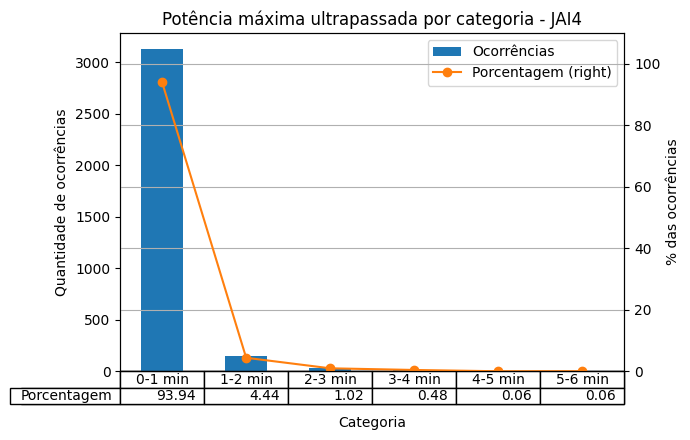

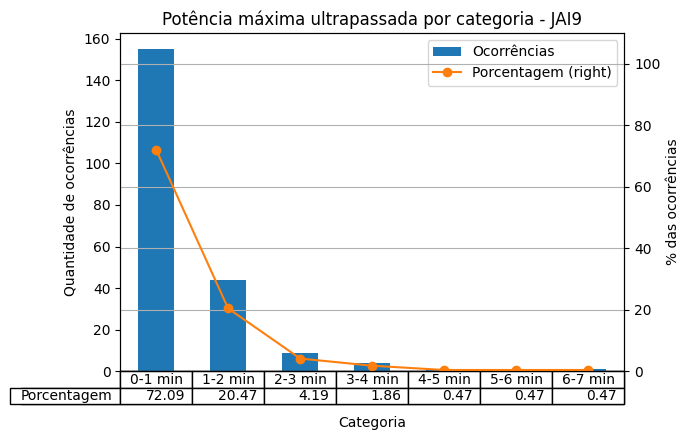

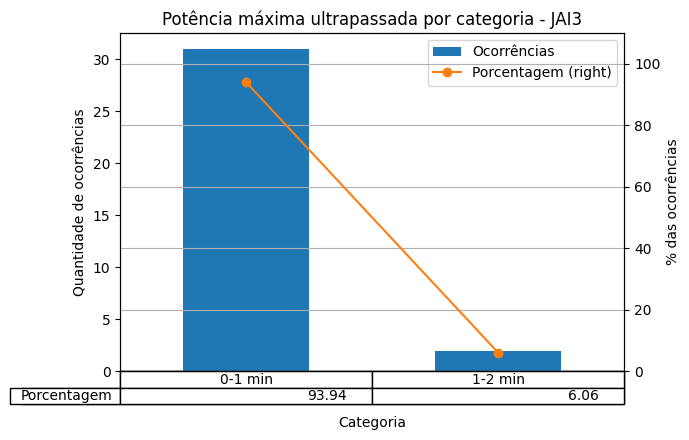

In [185]:
# DATA PLOTTING
plt.close('all')

plt.rcParams["figure.figsize"] = [7.00, 4.50] 
plt.rcParams["figure.autolayout"] = True

# BAR + LINE GRAPH
for zone in list(zones_timespan.keys()):
    
    data : pd.DataFrame = zones_timespan[zone]
    data['Timespan_sec'] = data['Timespan'].dt.total_seconds()

    interval : int = 60

    data['Category'] = pd.cut(
                data['Timespan_sec'].array,
                bins=range(0, int(data['Timespan_sec'].max()) + interval, interval),
                labels=[f'{i // interval}-{(i+interval) // interval} min' for i in range(0, int(data['Timespan_sec'].max()), interval)]
            )
    
    count_series = data['Category'].value_counts()
    percentage_series = ((count_series / count_series.sum()) * 100).round(decimals=2)
    plot_data = pd.DataFrame({'Category' : count_series.index, 'Count' : count_series, 'Percentage' : percentage_series})

    # print(plot_data)

    fig, axes = plt.subplots()
    ax1 = plot_data.plot(x='Category', y='Count',  kind='bar', ax=axes, title=f'{alarm_desired} por categoria - {zone}', table=True, stacked=True, label='Ocorrências', ylabel='Quantidade de ocorrências')
    ax2 = plot_data.plot(x='Category', y='Percentage', marker='o', color="C1", kind='line', ax=axes, secondary_y=True, table=True, grid=True, stacked=True, label='Porcentagem', xlabel='Categoria', ylabel='% das ocorrências')
    ax1.xaxis.labelpad = 15
    ax2.set_ylim([0,110])

    fig.savefig('./Figs/' + zone + '_Timespan.png')

    dump_df_to_csv(zone + '_Categorized', data)
    dump_df_to_csv(zone + '_Plot_Data', plot_data.drop(columns=['Category']))


JAI4
       Category  Count
Hours                 
7             7     17
8             8    124
9             9    453
10           10    627
11           11    733
12           12    805
13           13    463
14           14    111
JAI9
       Category  Count
Hours                 
7             7      8
8             8      2
9             9     39
10           10     39
11           11     44
12           12     73
13           13      9
14           14      1
JAI3
       Category  Count
Hours                 
7             7      1
8             8      4
9             9     21
10           10      4
11           11      3


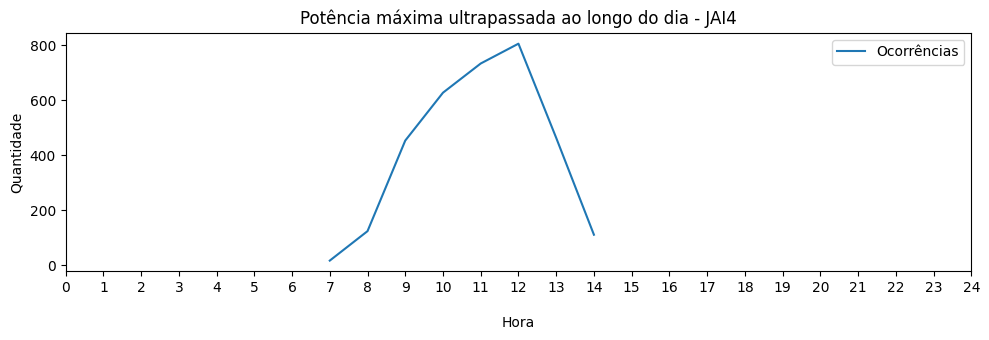

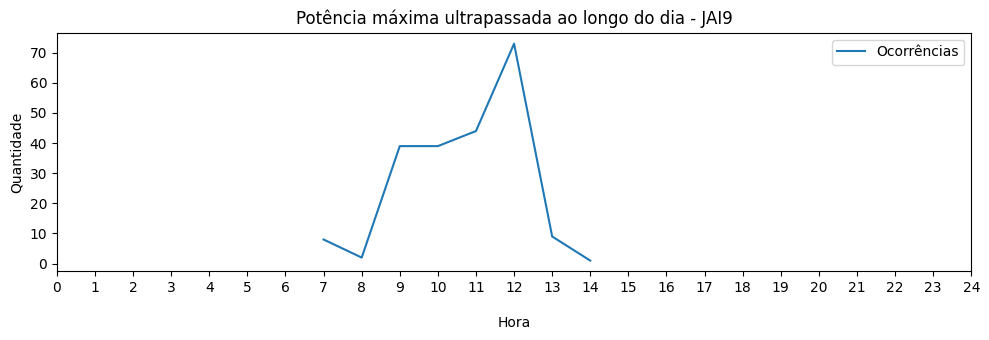

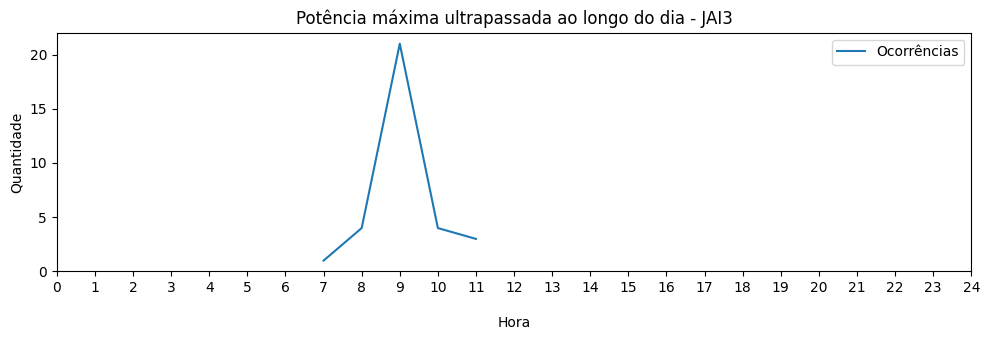

In [186]:
# CHECK THE OCCURENCE OF ALARMS THROUGH THE DAY
plt.rcParams["figure.figsize"] = [10.00, 3.50] 
plt.rcParams["figure.autolayout"] = True

for zone in list(zones_timespan.keys()):
    data : pd.DataFrame = pd.DataFrame()
    data['Hours'] = zones_timespan[zone]['Data e hora protocolo_Atuado'].dt.hour

    print(zone)
    # print(data.describe())
    
    interval : int = 1

    data['Category'] = pd.cut(
        data['Hours'].array,
        bins=range(0, 25, interval),
        labels=[f'{i}h' for i in range(0, 24, interval)],
        ordered=True
    )
    
    count_series = data['Hours'].value_counts().sort_index()
    plot_data = pd.DataFrame({'Category' : count_series.index, 'Count' : count_series})
    
    print(plot_data)

    fig, axes = plt.subplots()
    ax1 = plot_data.plot(x='Category', y='Count',  kind='line', ax=axes, title=f'{alarm_desired} ao longo do dia - {zone}', label='Ocorrências', xlabel='Hora', ylabel='Quantidade', xlim=(0, 24), xticks=[x for x in range(0, 25)])
    ax1.xaxis.labelpad = 15

    fig.savefig('./Figs/' + zone + '_DayLine.png')


In [198]:
# SAVE IMAGES TO PDF

from fpdf import FPDF

pdf = FPDF()
pdf.author = 'Mateus Konkol'
pdf.set_font('Arial', 'B', 16)
# imagelist is the list with all image filenames
for zone in zones:
    pdf.add_page()
    pdf.text(x=30, y=20, txt="Relatório de alarmes " + zone)
    pdf.image('./Figs/' + zone + '_Timespan.png', y=40, w=190)
    pdf.image('./Figs/' + zone + '_DayLine.png', y=170 ,w=190)

pdf.output(alarm_desired + ".pdf", "F")

''